In [1]:
import numpy as np
import pandas as pd
import os
import sys
import torch
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import optuna
import random
import joblib
from config import RESULTS_DIR, IMAGES_DIR, DATA_DIR, DATASET_PATH, MOTIF_INDEXES_PATH, K, N, P

print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")

os.makedirs(RESULTS_DIR, exist_ok=True)

if '__file__' in globals():
    # For standalone scripts
    base_dir = os.path.dirname(__file__)
else:
    # For Jupyter or interactive environments
    base_dir = os.getcwd()

# Add the parent directory of `utils` to the Python path
sys.path.append(os.path.abspath(os.path.join(base_dir, "../")))

2024-12-30 15:38:26,468 - INFO - Results will be saved in: /home/mgsilva/motifpred/results/syntheticdata1/variables=[0,2]
2024-12-30 15:38:26,468 - INFO - Images will be saved in: /home/mgsilva/motifpred/images/syntheticdata1/variables=[0,2]
2024-12-30 15:38:26,468 - INFO - Data will be accessed from: /home/mgsilva/motifpred/data/syntheticdata1/variables=[0,2]


Results will be saved in: /home/mgsilva/motifpred/results/syntheticdata1/variables=[0,2]
Images will be saved in: /home/mgsilva/motifpred/images/syntheticdata1/variables=[0,2]
Data will be accessed from: /home/mgsilva/motifpred/data/syntheticdata1/variables=[0,2]


In [2]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

Device: cuda
tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [3]:
data = np.genfromtxt(DATASET_PATH, delimiter=",").astype(int).reshape((K, N))
motif_indexes = np.genfromtxt(MOTIF_INDEXES_PATH, delimiter=",").astype(int)

print(motif_indexes)

[    0    10    22 ... 99922 99956 99992]


TRAIN: [    0     1     2 ... 15997 15998 15999] TEST: [16000 16001 16002 ... 19997 19998 19999]
TRAIN: [20000 20001 20002 ... 35997 35998 35999] TEST: [36000 36001 36002 ... 39997 39998 39999]
TRAIN: [40000 40001 40002 ... 55997 55998 55999] TEST: [56000 56001 56002 ... 59997 59998 59999]
TRAIN: [60000 60001 60002 ... 75997 75998 75999] TEST: [76000 76001 76002 ... 79997 79998 79999]
TRAIN: [80000 80001 80002 ... 95997 95998 95999] TEST: [96000 96001 96002 ... 99997 99998 99999]


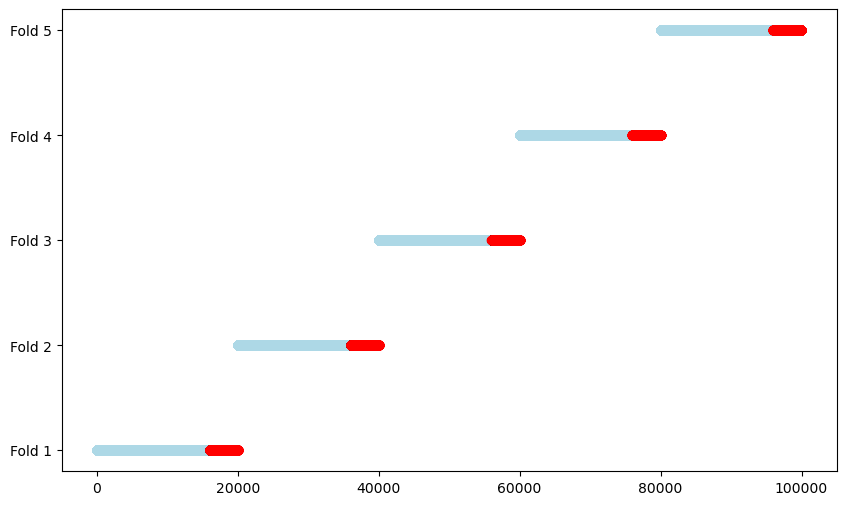

In [4]:
from utils.timeseries_split import BlockingTimeSeriesSplit

#create index  
indexes = np.arange(len(data[0]))

#split data
tscv = BlockingTimeSeriesSplit(n_splits=5)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o', color='lightblue')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'o', color='red')
    print("TRAIN:", train_index, "TEST:", test_index)
    

ax.set_yticks(np.arange(5), ["Fold {}".format(i) for i in range(1, 6)])
plt.show()

In [5]:
from utils.utils import create_dataset

lookback_period = 100 #window size
step = 5 #step size for the sliding window
forecast_period = 50 #forward window size

#X_series: past window, X_indices: indexes of the motif in the window,  y: next relative index of the motif
X_series, X_indices, y = create_dataset(data, lookback_period, step, forecast_period, motif_indexes)

#X_series is (num_samples, lookback_period, num_features)
X_mask = np.zeros((X_series.shape[0], X_series.shape[1])) 

for i, obs_motif_indexes in enumerate(X_indices):
    for j, idx in enumerate(obs_motif_indexes):
        idx = int(idx)
        X_mask[i, idx:idx+P] = 1

X_mask = torch.tensor(X_mask, dtype=torch.float32)

# X_series, X2, and y are now PyTorch tensors
print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, lookback_period)
print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X_series shape: torch.Size([19979, 100, 3])
X_mask shape: torch.Size([19979, 100])
X_indices shape: torch.Size([19979, 6, 1])
y shape: torch.Size([19979, 1])


[I 2024-12-30 15:38:38,496] A new study created in memory with name: no-name-c19691ad-d7c5-4676-865b-a936b67cf145
[I 2024-12-30 15:38:39,022] Trial 0 finished with value: inf and parameters: {'batch_size': 128}. Best is trial 0 with value: inf.


Best hyperparameters: {'batch_size': 128}
Number of finished trials:  1
Best trial: 0
Best hyperparameters: {'batch_size': 128}
Validation Losses: [inf, inf, inf, inf, inf]
Mean validation loss: inf
Test Losses: [90.999, 90.808, 90.672, 90.579, 90.506]
Mean test loss: 90.713
Mean test MAE: 7.219 std: 0.012
Mean test RMSE: 9.524 std: 0.009


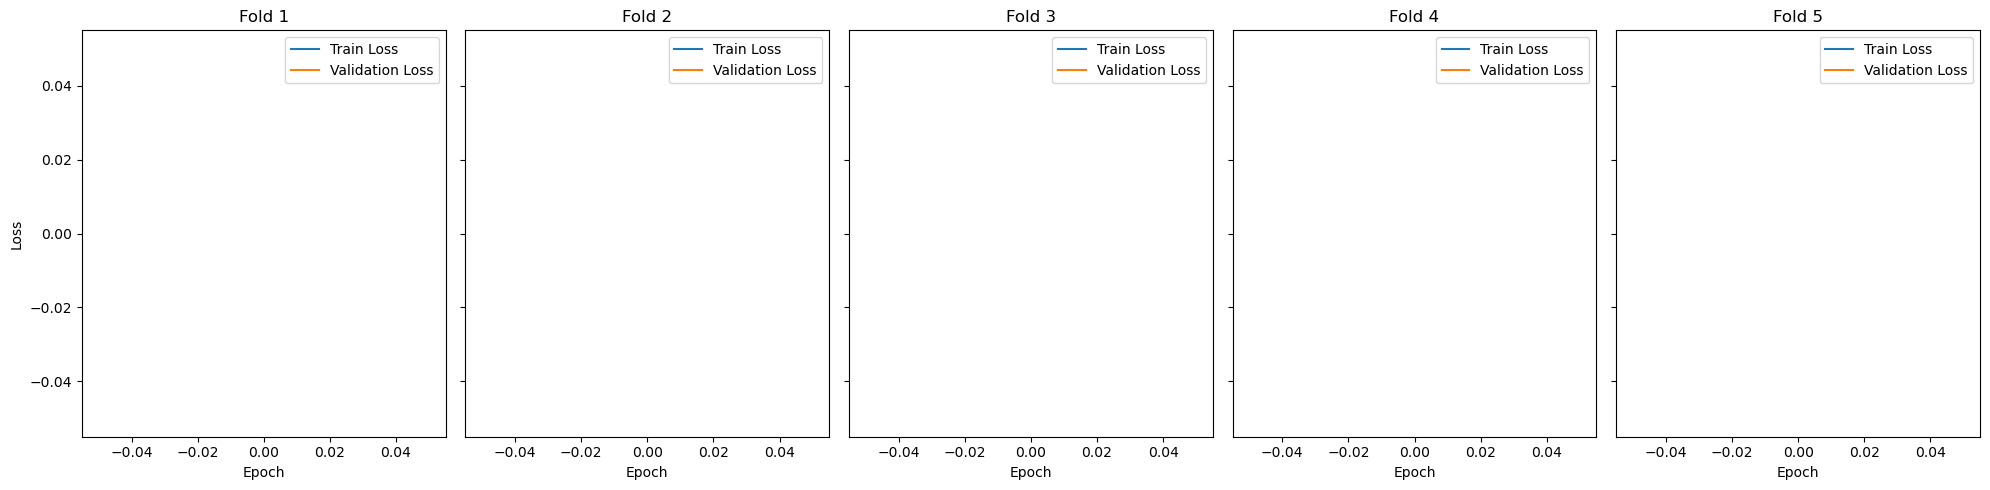

Best hyperparameters: {'batch_size': 128}
Validation Losses: [inf, inf, inf, inf, inf]
Mean validation loss: inf
Test Losses: [90.99871063232422, 90.80823516845703, 90.672119140625, 90.5791244506836, 90.50594329833984]
Mean test loss: 90.71282653808593


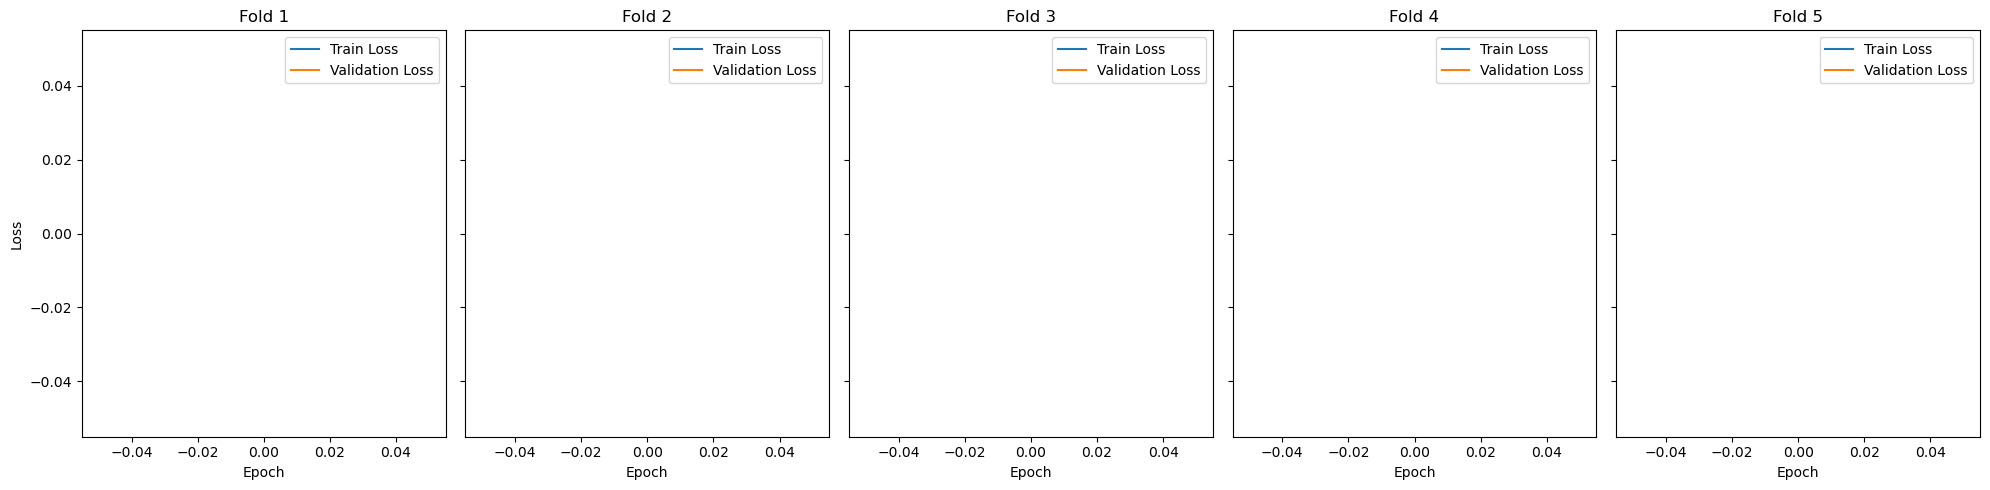

In [6]:
from models.baseline_pytorch import BaselineAverageModel
from utils.train_pipeline import run_optuna_study
from utils.utils import print_study_results, plot_best_model_results
from utils.train_pipeline import get_preds_best_config
from utils.utils import plot_preds_vs_truevalues

n_trials = 1
num_epochs = 1
model_type = "Baseline"
model_name = "BaselineAverageModel"

suggestion_dict = {
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}

model_params_keys = []


model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

run_optuna_study(pipeline.run_cross_val, BaselineAverageModel, model_type, suggestion_dict,  model_params_keys, seed, [X_series, X_mask, X_indices], y, [True, False, False], model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))


epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, BaselineAverageModel, model_type, model_params_keys, num_epochs =num_epochs, seed=seed, X=[X_series, X_mask, X_indices], y=y, normalize_flags=[True, False, False])

# Plot the train and validation losses for each fold
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
for i in range(5):
    axes[i].plot(epochs_train_losses[i], label="Train Loss")
    axes[i].plot(epochs_val_losses[i], label="Validation Loss")
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend()

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
plt.show()

# # Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))


[I 2024-12-30 15:39:07,821] A new study created in memory with name: no-name-24d47965-94cf-4f9c-b856-2a9bf9e75b24
[I 2024-12-30 15:39:08,183] Trial 0 finished with value: inf and parameters: {'batch_size': 128}. Best is trial 0 with value: inf.


Best hyperparameters: {'batch_size': 128}
Number of finished trials:  1
Best trial: 0
Best hyperparameters: {'batch_size': 128}
Validation Losses: [inf, inf, inf, inf, inf]
Mean validation loss: inf
Test Losses: [57.295, 57.358, 57.194, 57.325, 57.223]
Mean test loss: 57.279
Mean test MAE: 4.475 std: 0.007
Mean test RMSE: 7.568 std: 0.004


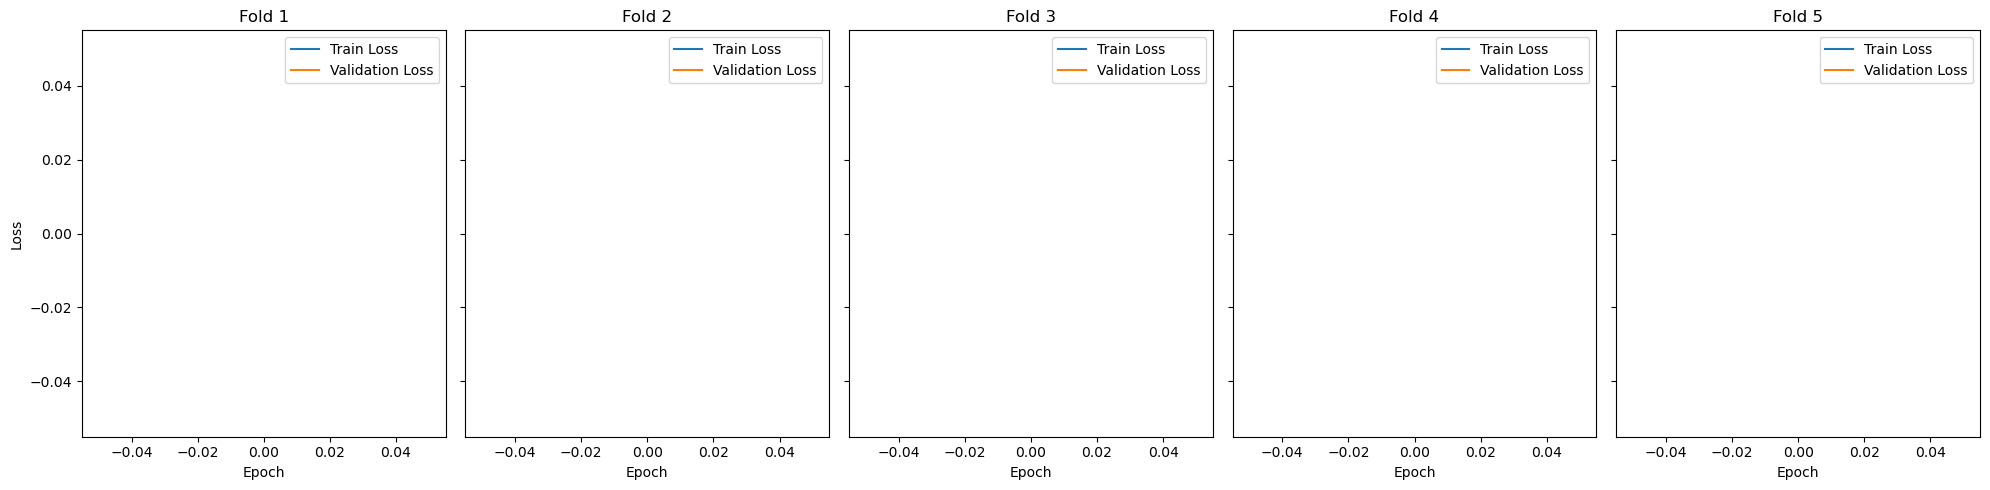

Best hyperparameters: {'batch_size': 128}
Validation Losses: [inf, inf, inf, inf, inf]
Mean validation loss: inf
Test Losses: [57.295372009277344, 57.357948303222656, 57.193992614746094, 57.325408935546875, 57.2227783203125]
Mean test loss: 57.279100036621095


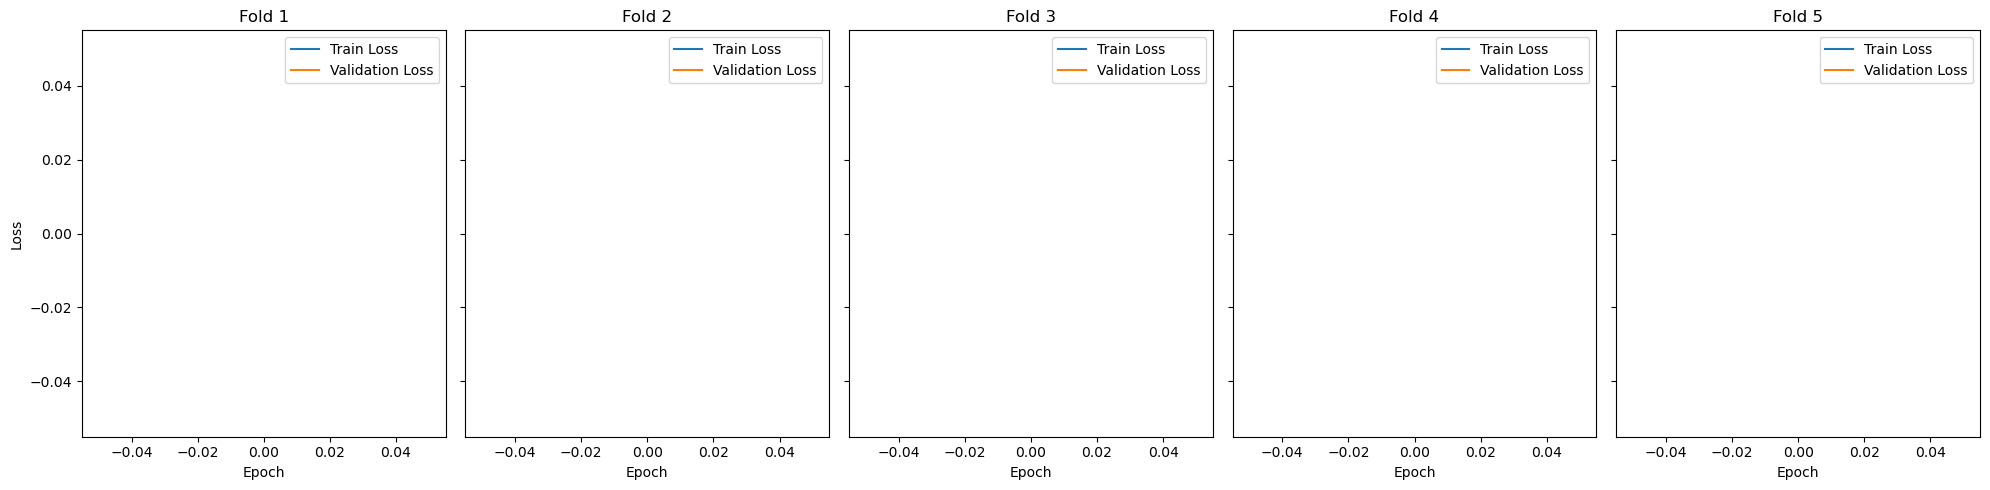

In [8]:
from models.baseline_pytorch import Baseline_NaiveLastDifference
from utils.train_pipeline import run_optuna_study
from utils.utils import print_study_results, plot_best_model_results

n_trials = 1
num_epochs = 1
model_type = "Baseline"
model_name = "Baseline_NaiveLastDifference"

suggestion_dict = {
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}


model_params_keys = []


model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

run_optuna_study(pipeline.run_cross_val, Baseline_NaiveLastDifference, model_type, suggestion_dict,  model_params_keys, seed, [X_series, X_mask, X_indices], y, [True, False, False], model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, Baseline_NaiveLastDifference, model_type, model_params_keys, num_epochs =num_epochs, seed=seed, X=[X_series, X_mask, X_indices], y=y, normalize_flags=[True, False, False])

# Plot the train and validation losses for each fold
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
for i in range(5):
    axes[i].plot(epochs_train_losses[i], label="Train Loss")
    axes[i].plot(epochs_val_losses[i], label="Validation Loss")
    axes[i].set_title(f"Fold {i + 1}")
    axes[i].set_xlabel("Epoch")
    if i == 0:
        axes[i].set_ylabel("Loss")
    axes[i].legend()

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
plt.show()

# # Plot the predictions vs true values for each fold
# for fold in range(5):
#     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
